In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_vaild, y_vaild),_) = pickle.load(f, encoding="latin-1")

(50000, 784)


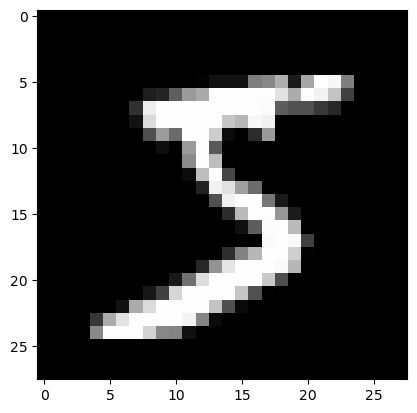

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
print(x_train.shape)

In [4]:
import torch

x_train, y_train, x_vaild, y_vaild = map(torch.tensor, (x_train, y_train, x_vaild, y_vaild))

n,c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [5]:
#torch.nn 없이 밑바닥부터 신경망 구성하기

import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [6]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(torch.matmul(xb, weights + bias))

In [7]:
bs = 64 #batch_size
xb = x_train[0:bs]
preds = model(xb) #예측
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.1726, -2.2468, -2.6792, -2.0706, -2.4376, -2.1838, -2.5120, -2.3128,
        -2.6113, -2.0239], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [8]:
def null(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = null

In [9]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3749, grad_fn=<NegBackward0>)


In [10]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [11]:
print(accuracy(preds, yb))

tensor(0.0312)


In [14]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [15]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(nan, grad_fn=<NegBackward0>) tensor(0.1875)


In [16]:
import torch.nn.functional as F
loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bs

In [17]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(nan, grad_fn=<NllLossBackward0>) tensor(0.1875)


In [20]:
from torch import nn

class Mnsit_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [21]:
model = Mnsit_Logistic()

In [22]:
print(loss_func(model(xb), yb))

tensor(2.1950, grad_fn=<NllLossBackward0>)


In [26]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
fit()

In [29]:
print(loss_func(model(xb), yb))

tensor(0.0855, grad_fn=<NllLossBackward0>)


In [32]:
class Mnsit_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
    
    def forward(self, xb):
        return self.lin(xb)

In [33]:
model = Mnsit_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3253, grad_fn=<NllLossBackward0>)


In [34]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0804, grad_fn=<NllLossBackward0>)


In [35]:
from torch import optim

def get_model():
    model = Mnsit_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred,yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
print(loss_func(model(xb), yb))

tensor(2.2541, grad_fn=<NllLossBackward0>)
tensor(0.0811, grad_fn=<NllLossBackward0>)


In [36]:
from torch.utils.data import TensorDataset

In [37]:
train_ds = TensorDataset(x_train, y_train)

In [38]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        xb, yb = train_ds[i * bs: i*bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0821, grad_fn=<NllLossBackward0>)


In [39]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [40]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
print(loss_func(model(xb), yb))

tensor(0.0816, grad_fn=<NllLossBackward0>)


In [41]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size= bs, shuffle=True)

vaild_ds = TensorDataset(x_vaild, y_vaild)
vaild_dl = DataLoader(vaild_ds, batch_size=bs * 2) 

In [42]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    model.eval()
    with torch.no_grad():
        vaild_loss = sum(loss_func(model(xb),yb) for xb, yb in vaild_dl)
    
    print(epoch, vaild_loss / len(vaild_dl))

0 tensor(0.3261)
1 tensor(0.2839)
